In [78]:
!python --version

Python 3.11.11


In [79]:
import torch
torch.__version__

'2.5.1+cu121'

In [80]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [81]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device # select gpu from edit -> notebook settings ->gpu

'cuda'

In [83]:
# Setup directory paths to train and test images
train_dir = 'AI_demos/custom_dataset/train'
test_dir = 'AI_demos/custom_dataset/test'

In [84]:
#  Create Datasets and DataLoaders

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [86]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [87]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5944ac89d0>,
 ['daisy', 'dandelion'])

torch.Size([3, 224, 224]) tensor(1)


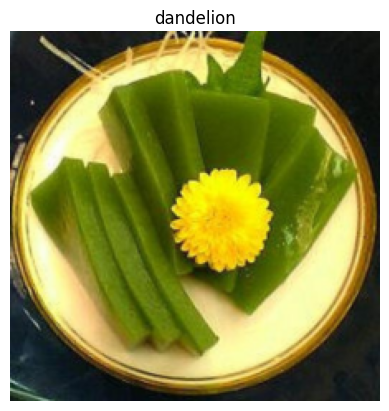

In [88]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [89]:
from AI_demos import vit_transformer_module
from AI_demos.vit_transformer_module import PatchEmbedding
from AI_demos.vit_transformer_module import MultiheadSelfAttentionBlock
from AI_demos.vit_transformer_module import MLPBlock
from AI_demos.vit_transformer_module import TransformerEncoderBlock
from AI_demos.vit_transformer_module import ViT

In [90]:
# Train our MOdel
# Create an instance of ViT with the number of classes we're working with (daisy, dandelion)
vit = ViT(num_classes=len(class_names))



# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()


from AI_demos import  engine
# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# Save the trained model's state_dict
torch.save(vit.state_dict(), '/content/drive/MyDrive/AI_demos/vit_trained_model.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7814 | train_acc: 0.3750 | test_loss: 6.9767 | test_acc: 0.5000
Epoch: 2 | train_loss: 6.7608 | train_acc: 0.5000 | test_loss: 4.9028 | test_acc: 0.5000
Epoch: 3 | train_loss: 4.8569 | train_acc: 0.5000 | test_loss: 1.3331 | test_acc: 0.5000
Epoch: 4 | train_loss: 1.3099 | train_acc: 0.5000 | test_loss: 2.0868 | test_acc: 0.5000
Epoch: 5 | train_loss: 2.0540 | train_acc: 0.5000 | test_loss: 1.6066 | test_acc: 0.5000
Epoch: 6 | train_loss: 1.5874 | train_acc: 0.5000 | test_loss: 0.8445 | test_acc: 0.5000
Epoch: 7 | train_loss: 0.8379 | train_acc: 0.5000 | test_loss: 1.1942 | test_acc: 0.5000
Epoch: 8 | train_loss: 1.1648 | train_acc: 0.5000 | test_loss: 0.6935 | test_acc: 0.5000
Epoch: 9 | train_loss: 0.6988 | train_acc: 0.4375 | test_loss: 1.0156 | test_acc: 0.5000
Epoch: 10 | train_loss: 0.9813 | train_acc: 0.5000 | test_loss: 0.7979 | test_acc: 0.5000


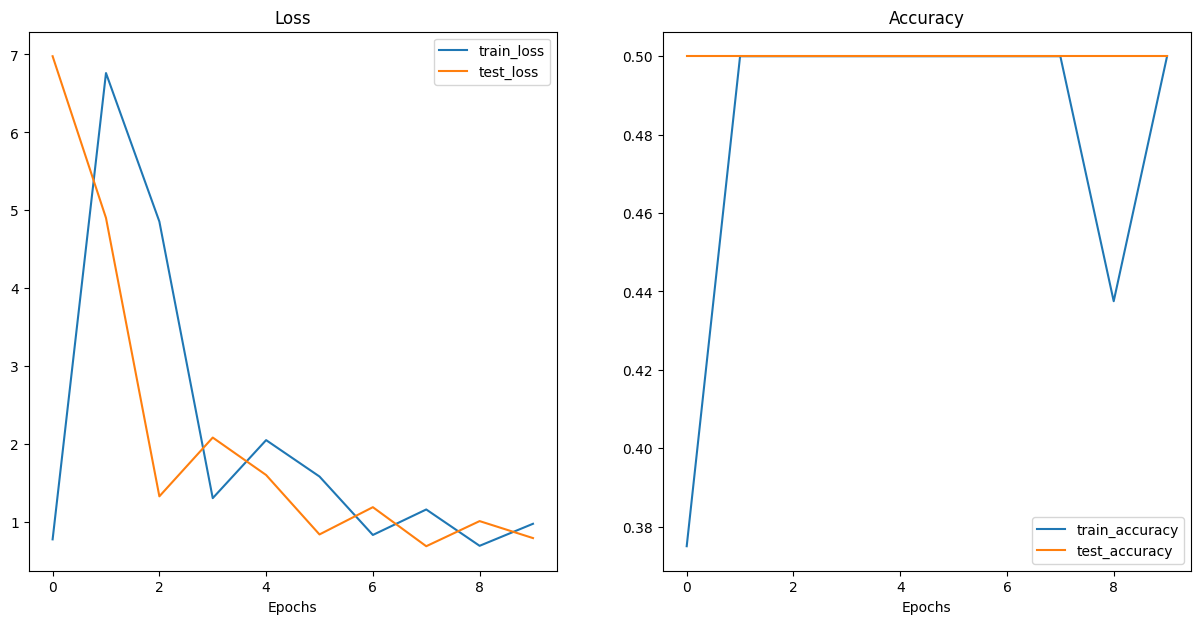

In [91]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from AI_demos.helper_functions import plot_loss_curves


# Plot our ViT model's loss curves
plot_loss_curves(results)

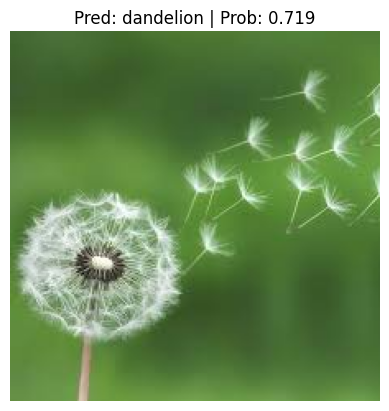

In [93]:
# Inference using trained model
import requests

# Import function to make predictions on images and plot them
from AI_demos.helper_functions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/AI_demos/test5.jpg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)